In [28]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa import statespace



In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [44]:
df = pd.read_csv('../data/winProxy.csv',parse_dates=True,index_col=0)
train_size = round(len(df) * 0.75)
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]
print("Number of training samples",len(train))
print("Number of testing samples",len(test))

Number of training samples 9721
Number of testing samples 3240


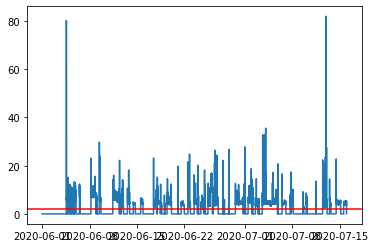

In [4]:
axes = plt.plot(df.CPU)
axes = plt.axhline(y =np.mean(df.CPU),color='r')

This tells us that over 45 days, we have an average utilization of 2%

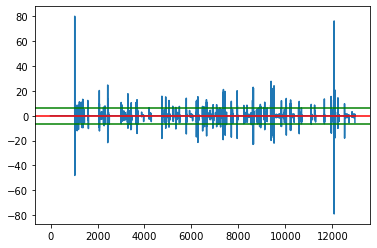

In [23]:
diff_series = pd.Series(np.ediff1d(df.CPU.values))

axes = plt.plot(diff_series)
axes = plt.axhline(y =np.mean(diff_series),color='r')
axes = plt.axhline(y =+3*np.std(diff_series),color='g')
axes = plt.axhline(y =-3*np.std(diff_series),color='g')

A large number of values are present within 3 standard deviations of the mean

In [24]:
stationarity_test = adfuller(diff_series.values)
print('ADF Statistic: %f' % stationarity_test[0])
print('p-value: %f' % stationarity_test[1])
print('Critical Values:')
for key, value in stationarity_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -27.546491
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


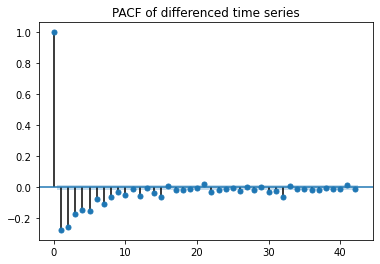

In [25]:
# To find the AR component , we need to plot the pacf
_ = plot_pacf(diff_series.values,title="PACF of differenced time series")

From, https://people.duke.edu/~rnau/411arim3.htm
Rule # 6 , the lag at which the PACF cuts off is indicated number of  AR terms

Here,Past 0 lag values are statistically significant

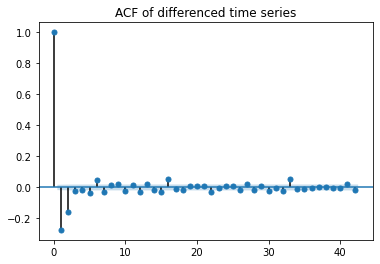

In [26]:
# To find the MA component , we need to plot the acf
_ = plot_acf(diff_series.values,title="ACF of differenced time series")

From, https://people.duke.edu/~rnau/411arim3.htm
Rule # 7 , the lag at which the ACF cuts off is the indicated number of  MA terms

Here,Past 6 lag values are statistically significant

In [165]:

mod = sm.tsa.statespace.SARIMAX(train.CPU.values, 
                          order=(0,1,6))
                          #seasonal_order=(0,1,6,288))
res = mod.fit()

In [166]:
out_of_sample_max_steps = 4
forecast = res.forecast(steps=out_of_sample_max_steps)
forecast = pd.Series(forecast)
forecast.index = test.index[:out_of_sample_max_steps]


In [167]:
mape(test.CPU[:out_of_sample_max_steps]+1,forecast+1)

9.039950413497515

In [170]:
smape(test.CPU[:out_of_sample_max_steps]+1,forecast+1)

8.632311885110958

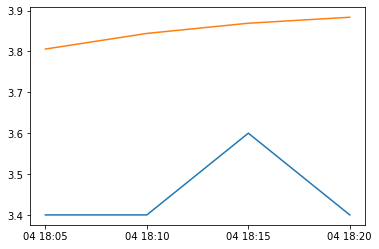

In [172]:
_ = plt.plot(test.CPU[:out_of_sample_max_steps])
_ = plt.plot(forecast)

Wavelet Denoising

In [146]:
WAVELET = "haar"

signal = df.CPU.values
coeffs = pywt.wavedec(signal, WAVELET)

coeffs[1:] = (pywt.threshold(detail,
                             value=0.5 * np.std(detail), 
                             mode="soft" ) for detail in coeffs[1:])
reconstructed_signal = pd.Series(pywt.waverec(coeffs, WAVELET)[:-1])
reconstructed_signal.index = df.index

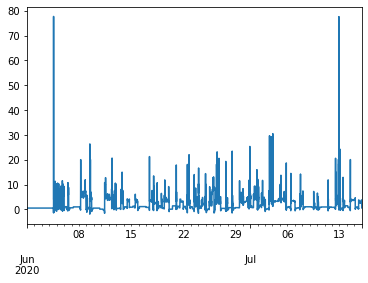

In [147]:
_ = reconstructed_signal.plot()

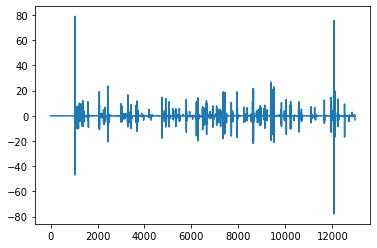

In [148]:
smooth_diff_series = pd.Series(np.ediff1d(reconstructed_signal.values))
_ = smooth_diff_series.plot()

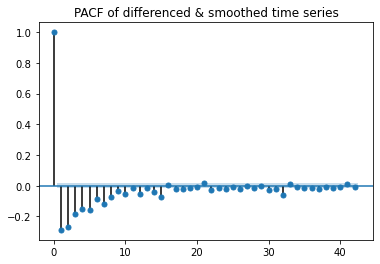

In [149]:
# To find the AR component , we need to plot the pacf
_ = plot_pacf(smooth_diff_series.values,title="PACF of differenced & smoothed time series")

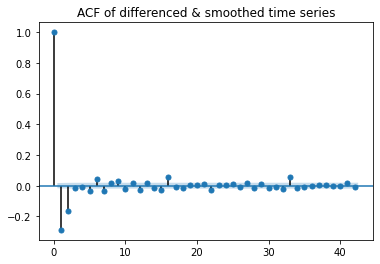

In [150]:
# To find the MA component , we need to plot the acf
_ = plot_acf(smooth_diff_series.values,title="ACF of differenced & smoothed time series")

In [151]:

mod = sm.tsa.statespace.SARIMAX(reconstructed_signal.values, 
                          order=(0,1,6))
                          
res = mod.fit()

In [159]:
out_of_sample_max_steps = 6
smoothed_forecast = res.forecast(steps=out_of_sample_max_steps)
smoothed_forecast = pd.Series(smoothed_forecast)
smoothed_forecast.index = test.index[:out_of_sample_max_steps]

In [160]:
mape(test.CPU[:out_of_sample_max_steps]+1,smoothed_forecast+1)

14.886419393553767

In [161]:
smape(test.CPU[:out_of_sample_max_steps]+1,smoothed_forecast+1)

16.363015580836034

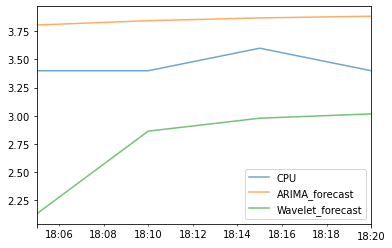

In [173]:
final = pd.DataFrame(test.CPU[:out_of_sample_max_steps])
final['ARIMA_forecast'] = forecast
final['Wavelet_forecast'] = smoothed_forecast

axes = final.plot(alpha = 0.65)
